<a href="https://colab.research.google.com/github/AlexHudnev/mla/blob/main/MLA_BlackJack_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm_notebook

In [ ]:
env = gym.make('Blackjack-v0')

In [ ]:
print('Пространство состояний: ', env.observation_space)
print('Действия: ', env.action_space)

Пространство состояний:  Tuple(Discrete(32), Discrete(11), Discrete(2))
Действия:  Discrete(2)


Состояния:

1. Сумма на руках игрока: 0...31
2. Стоимость карты дилера: 1...10
3. Есть ли у игрока туз, который можно использовать как 11: 0 или 1

Действия:

0. "Stick" - Пас, больше не брать.
1. "Hit" - взять ещё карту.


In [ ]:
# Посмотрим, как играет случайная стратегия

# Сначала функция стратегии
def policy_random(env, state):
  return env.action_space.sample() # Выбор случайного действия


# Проведём 5 игр с этой стратегией
for _ in range(5):
    state = env.reset()      # Запуск эпизода сначала, получаем первое состояние
    while True:
        print('Состояние: на руках', state[0], 'туз', state[2], 'у дилера:', state[1])
        
        action = policy_random(env, state)
        print('Действие:', 'Hit' if action else 'Stick')

        state, reward, done, info = env.step(action) # Выполняем действие, получаем:
                                                     #   следующее состояние, подкрепление, флаг завершения эпизода и диагностическую информацию
        if done:
            print('Эпизод завершён. Последнее подкрепление: ', reward)
            print('Терминальное состояние: на руках', state[0], 'туз', state[2], 'у дилера:', state[1])
            print('Выигрыш\n') if reward > 0 else print('Проигрыш\n')
            break

Состояние: на руках 14 туз False у дилера: 2
Действие: Stick
Эпизод завершён. Последнее подкрепление:  1.0
Терминальное состояние: на руках 14 туз False у дилера: 2
Выигрыш

Состояние: на руках 15 туз True у дилера: 9
Действие: Stick
Эпизод завершён. Последнее подкрепление:  1.0
Терминальное состояние: на руках 15 туз True у дилера: 9
Выигрыш

Состояние: на руках 15 туз False у дилера: 10
Действие: Stick
Эпизод завершён. Последнее подкрепление:  -1.0
Терминальное состояние: на руках 15 туз False у дилера: 10
Проигрыш

Состояние: на руках 10 туз False у дилера: 5
Действие: Stick
Эпизод завершён. Последнее подкрепление:  1.0
Терминальное состояние: на руках 10 туз False у дилера: 5
Выигрыш

Состояние: на руках 5 туз False у дилера: 7
Действие: Hit
Состояние: на руках 15 туз False у дилера: 7
Действие: Stick
Эпизод завершён. Последнее подкрепление:  -1.0
Терминальное состояние: на руках 15 туз False у дилера: 7
Проигрыш



Реализуем алгоритм оценки стратегии.
Сначала сделаем функцию, которая генерирует один эпизод.

In [ ]:
def generate_episode(env, strategy):
    """
    Функция генерации одного эпизода по заданной стратегии strategy в среде env.
    Возвращает список троек (состояние, действие, подкрепление)
    """
    episode = []
    state = env.reset() # Перезапускаем среду
    while True:
        action = strategy(env, state)    # Выбор действия
        next_state, reward, done, info = env.step(action)  # Выполнение действия
        episode.append((state, action, reward))            # Сохраняем историю
        state = next_state 
        if done:                  # Конец эпизода
            break
    return episode

# Посмотрим, как функция работает
print(generate_episode(env, policy_random))

[((9, 6, False), 1, 0.0), ((12, 6, False), 0, -1.0)]


Теперь сам алгоритм оценки стратегии. 
Вычисляем функцию ценности состояний методом Монте-Карло.

In [ ]:
def evaluate_policy(env, num_episodes, strategy):
    """
    Функция оценки стратегии методом Монте-Карло. Параметры:
      env - среда
      num_episodes - число эпизодов для оценки
      strategy - оцениваемая стратегия
      gamma - коэффициент дисконта
    Возвращает функцию ценности состояний в виде словаря: ключ - состояние, значение - ценность.
    """
    # Инициализация переменных
    returns_sum = defaultdict(float)  # Сумма возвратов
    N = defaultdict(int) # Число посещений
    Q = defaultdict(float) # Ценности состояний
    
    # Основной цикл по чилу эпизодов
    # tqdm_notebook рисует прогресс
    for _ in tqdm_notebook(range(num_episodes), 'Эпизоды'):
        # Генерируем эпизод
        episode = generate_episode(env, strategy)
        
        # Распаковываем состояния, действия и подкрепления в отдельные списки
        states, actions, rewards = zip(*episode)
        
        # Обновление суммы возвратов, числа посещений и ценности действий
        # для всех сосотояний в эпизоде.

        for i, state in enumerate(states): # Метод любого посещения
            returns_sum[state] += sum(rewards[i:])
            N[state] += 1.0
            Q[state] = returns_sum[state] / N[state]
            #Ценность действия - среднее значение возврата
    return Q

In [ ]:
# Запускаем расчёт функции ценности состояний
V_random = evaluate_policy(env, 500000, policy_random)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Теперь посторим графики функции ценности

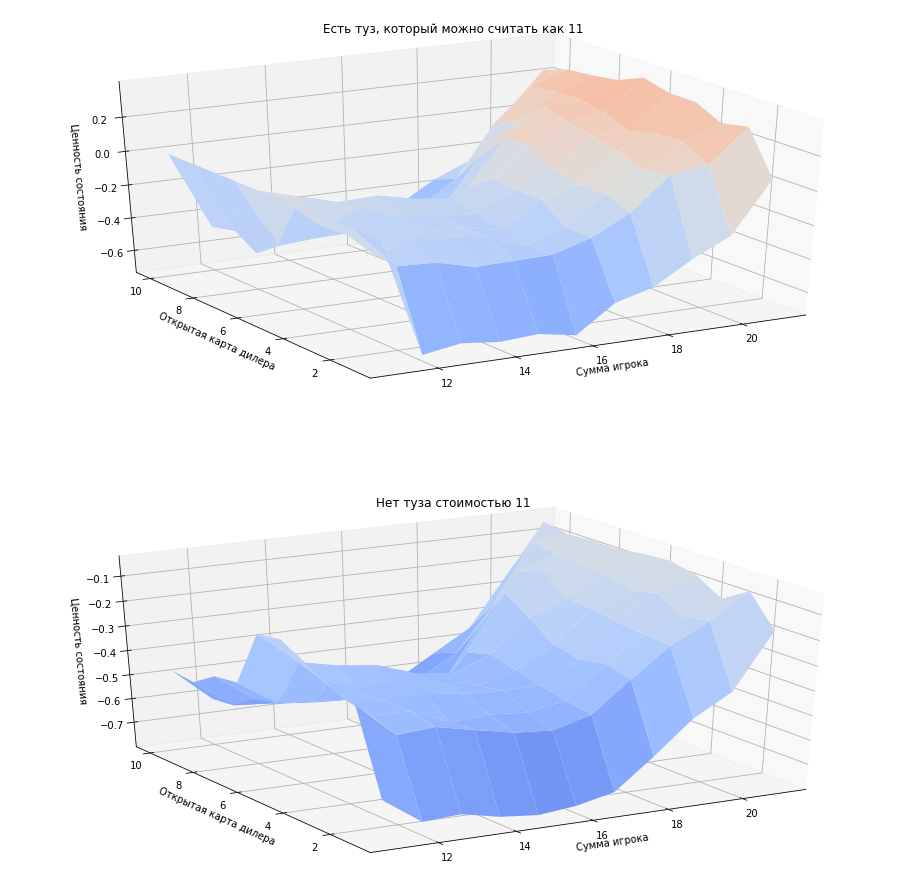

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Сумма игрока')
        ax.set_ylabel('Открытая карта дилера')
        ax.set_zlabel('Ценность состояния')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Есть туз, который можно считать как 11')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('Нет туза стоимостью 11')
    get_figure(False, ax)
    plt.show()
    

# Рисуем функцию ценности состояний
plot_blackjack_values(V_random)    

**Теперь проведите несколько экспериментов.**

*Задание 1*

In [ ]:
# Реализуйте функцию, которая использует такую же стратегию, как дилер:
# Брать, пока сумма <17, потом остановиться

def policy_dealer_like(env, state):
  return 1 if state[0] < 17 else 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


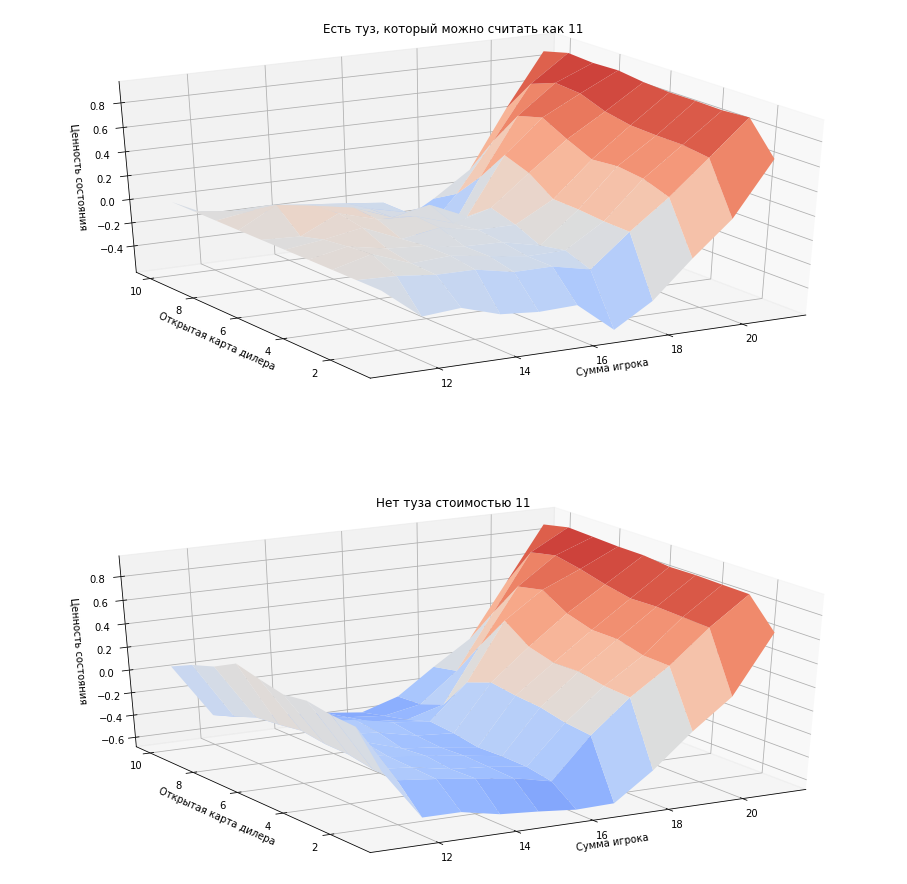

In [ ]:
# Вычислите функцию ценности для этой стратегии
V_policy_dealer_like = evaluate_policy(env, 500000, policy_dealer_like)
plot_blackjack_values(V_policy_dealer_like)    


*Задание 2*

In [ ]:
# Реализуйте функцию, которая использует следующую стратегию:
# если сумма  <17 брать с вероятностью 80% и останавливаться с вероятностью 20%;
# если сумма >=17 брать с вероятностью 20% и останавливаться с вероятностью 80%.

def policy_20_80(env, state):
  if  state[0] < 17:
     return 1 if np.random.rand() < 0.8 else 0
  else:
    return 0 if np.random.rand() < 0.8 else 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


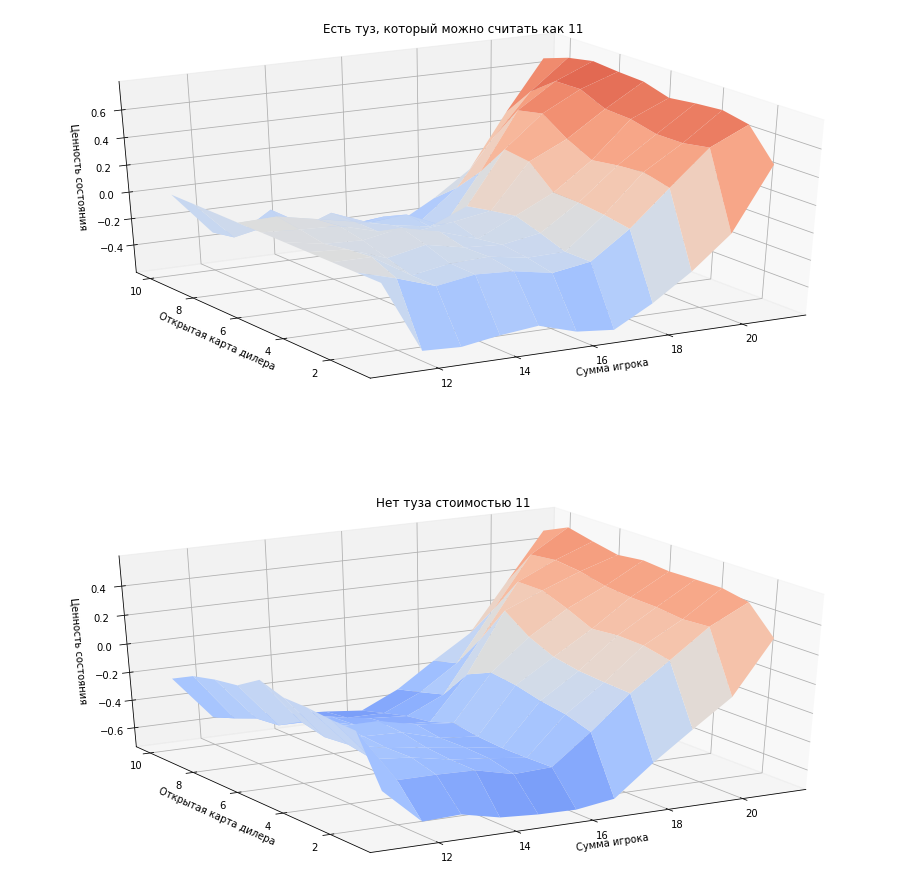

In [ ]:
# Вычислите функцию ценности для этой стратегии

V_policy_20_80 = evaluate_policy(env, 500000, policy_20_80)
plot_blackjack_values(V_policy_20_80)    


*Задание 3*

[(17, 9, True)]
-0.12545963229416468


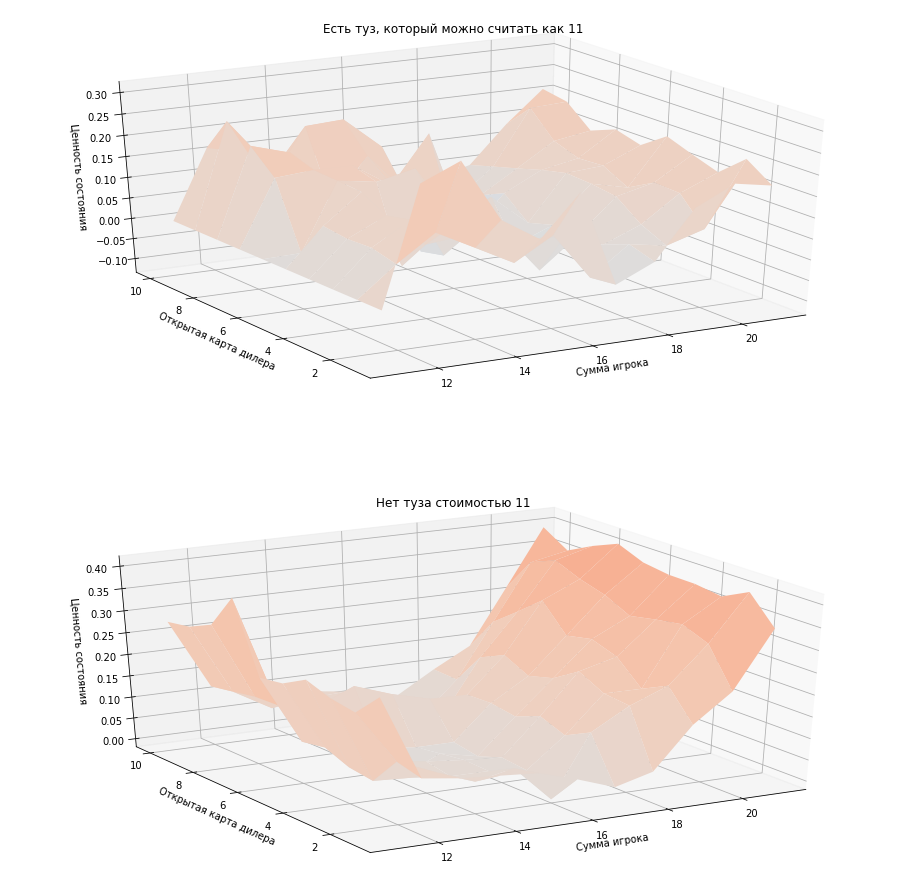

In [ ]:
# Сравните реализованные стратегии, установите в каких состояниях какая из них лучше. 

V_policy_dealer_like
delta = defaultdict(float)

for policy_dealer_like_key, policy_dealer_like_value in V_policy_dealer_like.items():
  for policy_20_80_key, policy_20_80_value in V_policy_20_80.items():
    if policy_20_80_key == policy_dealer_like_key: delta[policy_20_80_key] = policy_dealer_like_value - policy_20_80_value

temp = min(delta.values())

res = [key for key in delta if delta[key] == temp]
print(res)
print(temp)

plot_blackjack_values(delta)

## Судя по графикам разницы ценности состояний, стратегия '20 на 80'  оказывается лучше чем стратегия диллера  только когда у игрока на руках 17 и есть туз который можно считать за 11
## Случайная стратегия показывает результат хуже остальных

Теперь займёмся поиском оптимальной стратегии.

Сначала несколько вспомогательных функций.

In [ ]:
def e_greedy_probs(Q_s, epsilon, nA): #
    """
    Функция возвращает вероятности действий для е-жадной стратегии.
    Параметры:
      Q_s - функция ценности действий;
      epsilon - вероятность не жадного действия;
      nA - число доступных действий.
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
def policy_e_greedy(env, state, Q, epsilon):
  """
  Функция e-жадной стратегии.
  """
  if state in Q:
    return np.random.choice(np.arange(env.action_space.n), p=e_greedy_probs(Q, epsilon, env.action_space.n))
  else:
    return env.action_space.sample()  # Если нам ещё не встречалось такое состояние
                                      # выбираем случайное действие.

def generate_episode_from_Q(env, strategy, Q, epsilon):
    """
    Функция генерации одного эпизода. Модифицирована для передачи функции
    ценности действий Q
    """
    episode = []
    state = env.reset() # Перезапускаем среду
    while True:
        action = strategy(env, state, Q, epsilon)        # Выбор действия
        next_state, reward, done, info = env.step(action)  # Выполнение действия
        episode.append((state, action, reward))            # Сохраняем историю
        state = next_state 
        if done:                  # Конец эпизода
            break
    return episode


Основная функция расчёта оптимальной стратегии.

*Задание 4:  Реализуйте тело вычисления алгоритма управления методом Монте-Карло.*

In [ ]:
def mc_control(env, num_episodes, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # подготовка переменных
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Ценности действий
    N = defaultdict(lambda: np.zeros(env.action_space.n)) # Число посещений
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    epsilon = eps_start
    # Основной цикл по эпизодам
    for _ in tqdm_notebook(range(num_episodes), 'Эпизоды'):
        # Уменьшение epsilon со временем
        epsilon = max(epsilon*eps_decay, eps_min)

         # Реализуйте необходимые вычисления:
        # 1. Генерируйте эпизод используя е-жадную стратегию
        # 2. Распакуйте состояния, действия и подкрепления из эпизода в отдельные массивы
        # 3. Обновите функцию ценности действий для посещённых в эпизоде пар состояние-действие
        #    Можно использовать:
        #      N[state][action] - число посещений пары (состояние state, действие action)
        #      Q[state][action] - функция ценности действия

        # Генерируем эпизод
        episode = generate_episode_from_Q(env, policy_e_greedy, Q, epsilon)
        
        # Распаковываем состояния, действия и подкрепления в отдельные списки
        states, actions, rewards = zip(*episode)

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for i, (state, action)  in enumerate(sa_in_episode) :
            returns_sum[state][action] += sum(rewards[i:])
            N[state][action] += 1.0
            
            Q[state][action] = returns_sum[state][action] / N[state][action]


    # Вычисляем жадную стратегию по функции ценности действий
    policy = {k: np.argmax(v) for k, v in Q.items()}
    return policy, Q

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


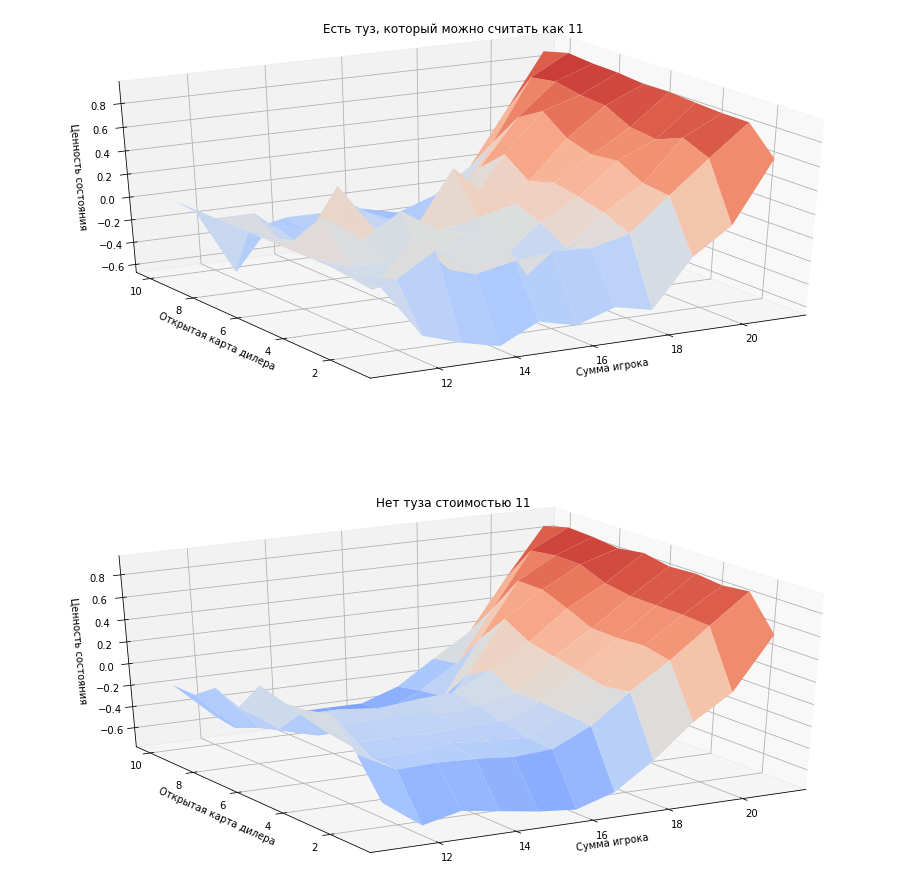

In [ ]:
# Вычислить оптимальную стратегию и функцию ценности действий
policy, Q = mc_control(env, 500000)

# Пересчитываем функцию ценности действий в функцию ценности состояний для жадной стратегии
V = {k: np.max(v) for k, v in Q.items()}

# Рисуем функцию ценности состояний
plot_blackjack_values(V)

Наконец нарисуем построенную стратегию.

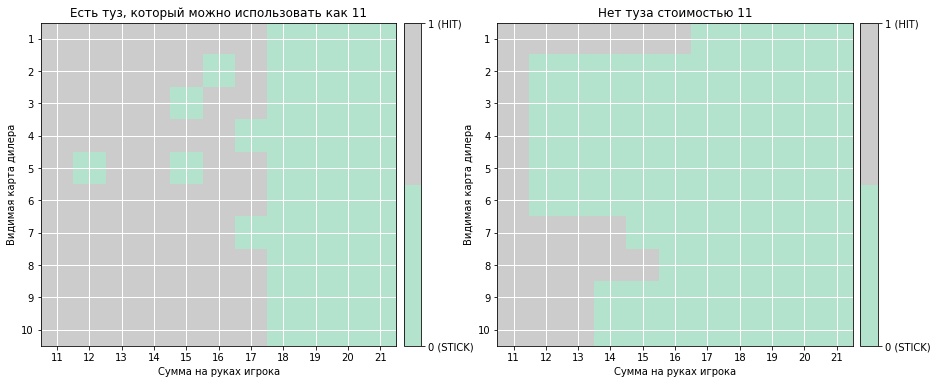

In [ ]:
def plot_policy(policy):
    """
    Функция рисования стратегии.
    """

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Сумма на руках игрока')
        ax.set_ylabel('Видимая карта дилера')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Есть туз, который можно использовать как 11')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('Нет туза стоимостью 11')
    get_figure(False, ax)
    plt.show()

# Рисуем стратегию
plot_policy(policy)

Оптимальная стратегия $\pi_*$ 
![true optimal policy $\pi_*$ t](https://github.com/udacity/deep-reinforcement-learning/raw/d6cb43c1b11b1d55c13ac86d6002137c7b880c15/monte-carlo/images/optimal.png)